In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import casadi as cas
plt.style.use('seaborn')

C:\Users\aless\AppData\Local\Temp\ipykernel_30496\418906186.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [153]:
n = 2
N = 10
dt = 10
TOL = 1e-4
opti = cas.Opti()
X = opti.variable(n, N+1)
U = opti.variable(n, N)
C = np.zeros((n,n))

x0 = np.array([100, 100])
u0 = np.array([1, 0])
ks = 10
kh = 0.5
alpha = 10 # Penalty on switching
C = np.array([[ks + kh, ks], [ks, ks + kh]])

cost = 0
for i in range(N):
    consumption =  C @ U[:, i] * dt
    value =  cas.sumsqr(X[:,i] - consumption ) 
    cost -= value
    cost += cas.if_else(cas.sumsqr(U[:,i] - U[:, i-1]) > TOL, 10,  0)

    opti.subject_to(X[:,i+1] == X[:,i] - consumption)
    opti.subject_to(U[0,i]**2 + U[1,i]**2 == 1)
    opti.subject_to( cas.mmax(U[:,i]) == 1)

value =  cas.sumsqr(X[:,N]) 
cost -= value

In [154]:
opti.minimize(cost)
opti.subject_to(X[:, 0] == x0)
opti.solver('ipopt')
sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      122
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       92

Total number of variables............................:       42
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       42
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+02 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [155]:
np.round(sol.value(U),0)

array([[0., 1., 0., 0., 0., 1., 0., 1., 1., 1.],
       [1., 0., 1., 1., 1., 0., 1., 0., 0., 0.]])

In [156]:
opti.value(cost)

-7751903.621431307

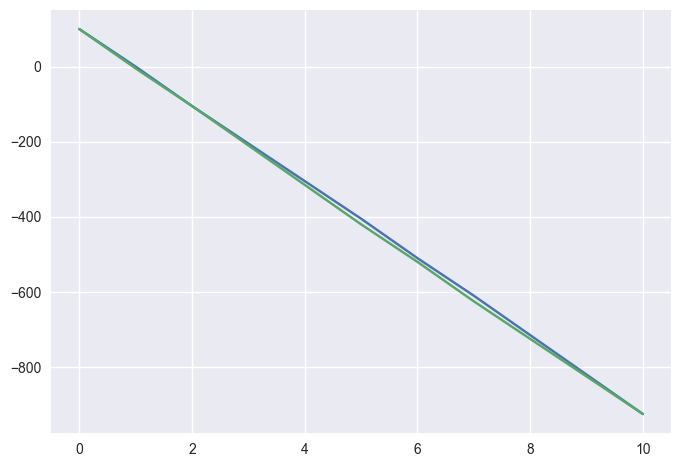

In [157]:
x1 = sol.value(X)[0,:]
x2 = sol.value(X)[1,:]
plt.plot(x1)
plt.plot(x2)
